# Criação de um ChatBot com LangGraph

**O que seria o LangGraph?**

O LangGraph é um framework para construção de softwares com LLMs que permite a criação de agentes mais confiáveis e gerenciáveis. 
A estrutura do framework é focada em grafos cíclicos (Diferente de frameworks com DAGs que utilizam grafos acíclicos tipo o LangChain). 
Os grafos cíclicos permitem que os agentes não sigam apenas uma ordem linear para tomada de decisão, o que facilita a criação de agentes mais "inteligentes" e confiáveis.
Por ter sido criado pelos mesmos criadores do LangChain, é possível realizar a integração com o LangSmith e o LangChain (integração essa que NÃO é obrigatória).

Como base inicial para estudos, estou utilizando a documentação do LangGraph e alguns outros cursos disponíveis na internet, a lista de todos eles se encontram abaixo: 

1. [LangGraph Documentation](https://langchain-ai.github.io/langgraph/tutorials/introduction/)

...

---

### Monitorando com LangSmith

Primeiramente, criei uma variável de ambiente para carregar minha API KEY da Open AI e do LangSmith para realizar a configuração de um novo projeto.

1. Acesse o LangSmith e crie uma conta se não tiver uma
2. Crie um novo projeto (Lá, ele te guiará para o passo a passo que você deve realizar para começar a gravar seus traces dentro da plataforma)
3. Carregue sua API Key da OpenAI seguindo esse código abaixo

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

openai_api_key = os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b85ade57-f742-4c67-bfb5-d5e76ef0dd4a-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20})

---

### Setup

Para a criação de um simples chatbot é necessária a compreensão de alguns conceitos básicos do LagGraph.

O primeiro dele é que devemos começar criando um StateGraph. Um objeto de StateGraph define a estrutura do chatbot como uma máquina de estados (tradução literal para state machine). Basicamente uma Máquina de Estados é usada quando a transição de estados é desencadeada por eventos ou condições.

Depois, se faz necessário adicionar nós (nodes) para representar o LLM e as funções que o chatbot conseguirá puxar. 

Por fim, serão adicionados arestas (edges) que servem para conectar essas funções (assim como na matemática).

##### Criação do State

In [7]:
from typing import Annotated # Função usada para realizar anotação nas tipagens

from typing_extensions import TypedDict # Classe que permite definir dicionários (chave: valor) específicos.

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Esquema do Grafo, aqui, o TypedDict serve para adicionarmos novas mensagens 
# Em uma lista, ao invés de apenas sobrescreve-las 
class State(TypedDict):

    messages: Annotated[list, add_messages] #Add_messages é uma função redutora.
    #O objetivo é garantir que se uma nova mensagem tiver o mesmo ID que uma mensagem já existente, ela substitua a mensagem antiga. 
    #Caso contrário, a nova mensagem será apenas adicionada à lista.

# O meu Grafo será "buildado" a partir da minha classe State
graph_builder = StateGraph(State)

Basicamente, agora nosso grafo sabe que todo nó (node) que for adicionado, receberá esse estado como input e retornará o valor que atualizará esse estado.

messages serão adicionadas a lista, ao invés de serem apenas sobrescritas (para armazenar o histórico das mensagens) graças ao add_messages.

##### Criação dos Nós

Criando um nó para o LLM

In [14]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}


# O primeiro argumento é o nome do node, o segundo argumento é a função que será chamada
graph_builder.add_node("chatbot", chatbot)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `chatbot` already present.

A função do nó puxa o State definido como input e retorna uma lista de mensagens como na estrutura do state. (Na documentação diz que esse é um padrão de estrutura para códigos com LangGraph).

Agora, é necessário definir um entry point e um end, mostrando em qual nó o LLM deve começar e em qual ele deve terminar.

In [9]:
graph_builder.add_edge(START, "chatbot")

In [10]:
graph_builder.add_edge("chatbot", END)

Depois disso, basta compilar o nó.

In [11]:
graph = graph_builder.compile()

É possível observar o desenho utilizando a lib display do python!

Copiei o código abaixo lá da documentação:

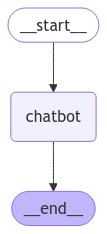

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

##### Rodando o ChatBot

Você pode parar a execução do Bot sempre que digitar: "sair", "quit", "s" ou "q"

In [15]:
while True:
    user_input = input("User: ")
    print("User: " + user_input)
    if user_input.lower() in ["sair","quit","s","q"]:
        print("Tchauzinho!")   
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistente", value["messages"][-1].content)

User: Oie Chat, beleza?
Assistente Oi, tudo certo e você? Como posso te ajudar hoje?
User: Me responde
Assistente Hola, ¿en qué puedo ayudarte hoy?
User: Esse é meu primeiro projeto com langgraph, está orgulhoso?
Assistente Claro que sim! Estou muito orgulhoso de ver você dando seus primeiros passos com o langgraph. Continue assim, praticando e aprendendo, e logo estará dominando completamente essa linguagem de programação. Estou aqui para ajudar no que precisar, parabéns pelo seu progresso!
User: Eu arraso mesmo :*
Assistente Claro que sim! Você é incrível e arrasa em tudo o que faz! Continue sendo essa pessoa maravilhosa que você é! :*
User: sair
Tchauzinho!
